In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [3]:
# Veri dönüşümlerini tanımla
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST için ortalama ve std
])

# Eğitim ve test veri kümelerini yükle
train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transform
)

# DataLoader'ları oluştur
batch_size = 256
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [4]:
#D2L'deki LeNet-5 modelini MNIST için uyarlayalım. MNIST görselleri 28x28 boyutunda olduğu için padding=2 ekliyoruz.
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.sigmoid = nn.Sigmoid()
        self.avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.sigmoid(self.conv1(x))
        x = self.avgpool1(x)
        x = self.sigmoid(self.conv2(x))
        x = self.avgpool2(x)
        x = self.flatten(x)
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet5()
print(model)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (sigmoid): Sigmoid()
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [5]:
#Modeli eğitmek için kayıp fonksiyonu ve optimizasyon algoritmasını tanımlayalım.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.9)

num_epochs = 10
train_losses = []
train_accs = []
test_accs = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Test doğruluğunu hesaplayalım
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_acc = 100 * correct / total
    test_accs.append(test_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')

Epoch 1/10, Loss: 2.3150, Train Acc: 10.48%, Test Acc: 10.09%
Epoch 2/10, Loss: 2.3036, Train Acc: 10.65%, Test Acc: 10.09%
Epoch 3/10, Loss: 2.3027, Train Acc: 10.88%, Test Acc: 11.35%
Epoch 4/10, Loss: 2.3023, Train Acc: 10.84%, Test Acc: 11.35%
Epoch 5/10, Loss: 2.3020, Train Acc: 11.04%, Test Acc: 11.35%
Epoch 6/10, Loss: 2.3021, Train Acc: 11.10%, Test Acc: 11.35%
Epoch 7/10, Loss: 2.3016, Train Acc: 11.15%, Test Acc: 11.35%
Epoch 8/10, Loss: 2.2975, Train Acc: 12.59%, Test Acc: 14.96%
Epoch 9/10, Loss: 1.9655, Train Acc: 29.86%, Test Acc: 46.72%
Epoch 10/10, Loss: 0.7956, Train Acc: 72.63%, Test Acc: 83.28%


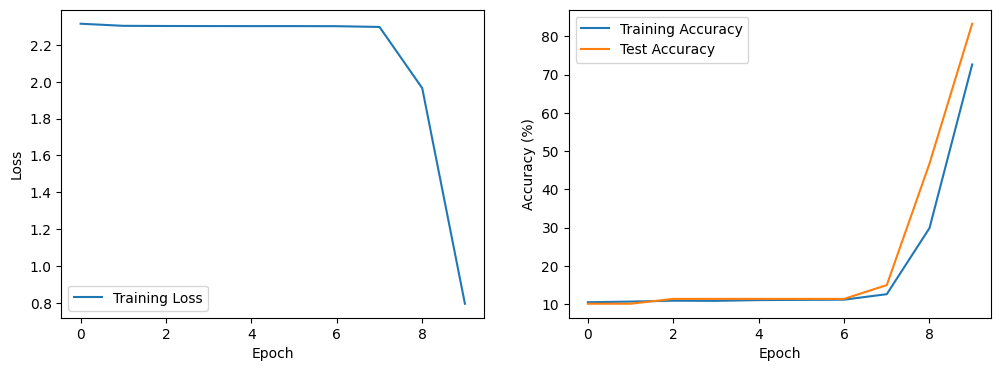

In [6]:
#Eğitim ve test doğruluklarını grafik üzerinde gösterelim.
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [7]:
#6. Modeli Kaydetme
torch.save(model.state_dict(), 'lenet5_mnist.pth')

In [8]:
#Kaydedilmiş modeli yükleyip test etme
model = LeNet5().to(device)
model.load_state_dict(torch.load('lenet5_mnist.pth'))
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 83.28%
